# Step 1

In [70]:
import scipy.io, scipy.interpolate

pred_data = scipy.io.loadmat("leaderboard_data.mat")
proj_data = scipy.io.loadmat("raw_training_data.mat")

# Extract dataglove and ECoG data from the picke file for each subject
data_glove = proj_data['train_dg']
ecog = proj_data['train_ecog']

# Initialize lists to store training and testing data for each subject
train_data_glove = []
test_data_glove = []
train_ecog = []
test_ecog = []

# Split data into training and testing sets for each subject
for i in range(len(data_glove)):
    # Get the number of samples for the current subject
    num_samples = data_glove[i][0].shape[0]

    # Calculate the split index (50% of the data for training)
    split_idx = int(num_samples * 2/3)

    # train_ecog, X_test, y_train, y_test = train_test_split(ecog, data_glove, test_size=0.5, random_state=42)

    # Split dataglove data
    train_data_glove.append(data_glove[i][0][:split_idx])
    test_data_glove.append(data_glove[i][0][split_idx:])

    # Split ECoG data
    train_ecog.append(ecog[i][0][:split_idx])
    test_ecog.append(ecog[i][0][split_idx:])

# Print the number of samples in the full ECoG recording for each subject
for i in range(len(ecog)):
    print(f"Subject {i+1} - Full ECoG samples: {ecog[i].shape[0]}")

# Print the number of samples in the training and testing sets for each subject
for i in range(len(train_ecog)):
    print(f"Subject {i+1} - Training samples: {train_ecog[i].shape[0]}, Testing samples: {test_ecog[i].shape[0]}")

print(f"train_ecog shape: {train_ecog[0].shape}")

Subject 1 - Full ECoG samples: 1
Subject 2 - Full ECoG samples: 1
Subject 3 - Full ECoG samples: 1
Subject 1 - Training samples: 200000, Testing samples: 100000
Subject 2 - Training samples: 200000, Testing samples: 100000
Subject 3 - Training samples: 200000, Testing samples: 100000
train_ecog shape: (200000, 62)


In [75]:
import numpy as np
def gen_windows(data, window_length, window_overlap, fs=1000):
    # Convert window length and overlap from milliseconds to number of samples
    window_length_samples = int(window_length * fs / 1000)
    window_overlap_samples = int(window_overlap * fs / 1000)

    # Calculate the number of windows
    num_windows = (data.shape[0] - window_length_samples) // (window_length_samples - window_overlap_samples) + 1

    # Initialize the feature windows array
    feature_windows = np.zeros((num_windows, window_length_samples, data.shape[1]))

    # Generate the feature windows
    for i in range(num_windows):
        start_idx = i * (window_length_samples - window_overlap_samples)
        end_idx = start_idx + window_length_samples
        feature_windows[i] = data[start_idx:end_idx]

    return feature_windows

# Generate feature windows for each subject
for i in range(len(ecog)):
    window_length = 100
    window_overlap = 50

    feature_windows = gen_windows(ecog[i][0], window_length, window_overlap)
    # dim 1: number of feature windows generated
    # dim 2: window length in samples (since it was set to 100 ms)
    # dim 3: number of channels in the input ECoG data for each subject
    print(f"Subject {i+1} - Feature windows shape: {feature_windows.shape}")

Subject 1 - Feature windows shape: (5999, 100, 62)
Subject 2 - Feature windows shape: (5999, 100, 48)
Subject 3 - Feature windows shape: (5999, 100, 64)


In [98]:
import numpy as np
import scipy.signal

def extract_features(window, fs=1000):
    features = []

    # Time-domain feature: Mean voltage
    mean_voltage = np.mean(window, axis=0)
    features.append(mean_voltage)

    # Frequency-domain features
    nperseg = window.shape[0]  # Full window for frequency analysis
    f, Pxx = scipy.signal.welch(np.transpose(window), fs=fs, nperseg=nperseg)

    # Define frequency bands
    bands = [(5, 15), (20, 25), (75, 115), (125, 160), (160, 175)]
    epsilon = 1e-10  # Small value to avoid log(0)

    # Log band powers
    for low, high in bands:
        mask = (f >= low) & (f <= high)
        if np.any(mask):
            band_power = np.mean(Pxx[:, mask], axis=1)
            log_band_power = np.log(band_power + epsilon)
        else:
            log_band_power = np.zeros(Pxx.shape[0])
        features.append(log_band_power)

    # High Frequency Broadband (70–200 Hz)
    hfb_mask = (f >= 70) & (f <= 200)
    if np.any(hfb_mask):
        hfb_power = np.mean(Pxx[:, hfb_mask], axis=1)
        log_hfb_power = np.log(hfb_power + epsilon)
    else:
        log_hfb_power = np.zeros(Pxx.shape[0])
    features.append(log_hfb_power)

    # Hilbert Envelope Feature
    from scipy.signal import hilbert

    # Apply Hilbert transform along time (axis 0)
    analytic_signal = hilbert(window, axis=0)
    envelope = np.abs(analytic_signal)

    # Take mean envelope value across the window for each channel
    mean_envelope = np.mean(envelope, axis=0)
    features.append(mean_envelope)

    return np.concatenate(features)

def gen_windows(data, window_length, window_overlap, fs=1000):
    # Convert window length and overlap from milliseconds to number of samples
    window_length_samples = int(window_length * fs / 1000)
    window_overlap_samples = int(window_overlap * fs / 1000)

    # Calculate the number of windows
    num_windows = (data.shape[0] - window_length_samples) // (window_length_samples - window_overlap_samples) + 1

    # Initialize the feature windows array
    feature_windows = np.zeros((num_windows, window_length_samples, data.shape[1]))

    # Generate the feature windows
    for i in range(num_windows):
        start_idx = i * (window_length_samples - window_overlap_samples)
        end_idx = start_idx + window_length_samples
        feature_windows[i] = data[start_idx:end_idx]

    return feature_windows

# Generate feature windows and extract features for each subject
for i in range(len(ecog)):
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(ecog[i][0], window_length, window_overlap)

    # Extract features from each window
    all_features = np.array([extract_features(window) for window in feature_windows])
    print(f"Subject {i+1} - Extracted features shape: {all_features.shape}")


Subject 1 - Extracted features shape: (5999, 496)
Subject 2 - Extracted features shape: (5999, 384)
Subject 3 - Extracted features shape: (5999, 512)


#Step 2

In [99]:
import numpy as np
import scipy.interpolate

def interpolate_dataglove(data, num_samples, fs=1000):
    # Calculate the original timestamps based on the sampling rate
    original_times = np.arange(len(data)) / fs

    # Calculate new timestamps where we want the interpolated values
    # Assuming that each feature window corresponds to the start of each window in ECoG data
    new_times = np.arange(num_samples) * 0.05  # Every 50 ms for each window

    # Interpolation
    interpolated = np.zeros((num_samples, data.shape[1]))

    for i in range(data.shape[1]):  # Assuming data has multiple channels
        interpolator = scipy.interpolate.interp1d(original_times, data[:, i], kind='linear', bounds_error=False, fill_value="extrapolate")
        interpolated[:, i] = interpolator(new_times)
    return interpolated

In [100]:
# Generate feature windows for each subject
for i in range(len(train_ecog)):
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(train_ecog[i], window_length, window_overlap)
    all_train_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    downsampled_train_dg = interpolate_dataglove(train_data_glove[i], len(all_train_features))

    print(f"Subject {i+1} - Extracted features shape: {all_train_features.shape}, Dataglove shape: {downsampled_train_dg.shape}")

for i in range(len(test_ecog)):
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(test_ecog[i], window_length, window_overlap)
    all_test_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    downsampled_test_dg = interpolate_dataglove(test_data_glove[i], len(all_test_features))

    print(f"Subject {i+1} - Extracted features shape: {all_test_features.shape}, Dataglove shape: {downsampled_test_dg.shape}")

Subject 1 - Extracted features shape: (3999, 496), Dataglove shape: (3999, 5)
Subject 2 - Extracted features shape: (3999, 384), Dataglove shape: (3999, 5)
Subject 3 - Extracted features shape: (3999, 512), Dataglove shape: (3999, 5)
Subject 1 - Extracted features shape: (1999, 496), Dataglove shape: (1999, 5)
Subject 2 - Extracted features shape: (1999, 384), Dataglove shape: (1999, 5)
Subject 3 - Extracted features shape: (1999, 512), Dataglove shape: (1999, 5)


In [101]:
def prepare_data(features, targets, lag=3):
    # Assumes features are ordered chronologically
    # Create lagged feature matrix X
    X = np.array([features[i:i+lag].flatten() for i in range(len(features) - lag + 1)])
    # Align target matrix Y to the end of each lagged feature set
    Y = targets[lag-1:]
    return X, Y

In [102]:
def ridgePrediction(X, Y, lambda_reg=1e-2):
    XT = np.transpose(X)
    n_features = X.shape[1]
    XTX_plus_lambdaI = np.matmul(XT, X) + lambda_reg * np.eye(n_features)
    beta = np.matmul(np.linalg.inv(XTX_plus_lambdaI), np.matmul(XT, Y))
    return beta

In [103]:
import numpy as np
import scipy.interpolate

def cubic_spline_interpolation(y, old_freq, new_freq, total_duration):
    # Generate old timestamps: every 50 ms
    old_times = np.linspace(0, total_duration, int(total_duration*old_freq))

    # Generate new timestamps: every 1 ms
    new_times = np.linspace(0, total_duration, int(total_duration*new_freq))

    new_y = np.zeros((int(total_duration*new_freq), 5))

    # Interpolate using Cubic Spline
    for columnIndex in range(y.shape[1]):
      interpolator = scipy.interpolate.CubicSpline(old_times, y[:, columnIndex], bc_type='clamped')  # Using 'clamped' to avoid blowup at the edges
      new_y[:, columnIndex] = interpolator(new_times)
    print(new_y.shape)

    return new_times, new_y

def pad_data(interpolated_data, original_length):
    # Calculate padding sizes
    pad_before = (original_length - len(interpolated_data)) // 2
    pad_after = original_length - len(interpolated_data) - pad_before

    # Pad with zeros
    padded_data = np.pad(interpolated_data, ((pad_before, pad_after), (0,0)), mode='constant')

    return padded_data

# # Assume Y_hat are the predicted values at 20 Hz (every 50 ms), and the original data length was at 1000 Hz
original_length = len(test_data_glove[0])  # Calculate original length assuming original data was 1000 Hz over the same time period
total_duration = len(trainPreds) * 0.05  # Total duration in seconds

# # Interpolate the predictions
_, interpolated_predictions = cubic_spline_interpolation(trainPreds, old_freq=20, new_freq=1000, total_duration=total_duration)

# # Padding to match the original data's length
padded_predictions = pad_data(interpolated_predictions, original_length)

print("Interpolated and Padded Predictions Shape:", padded_predictions.shape)


(99850, 5)
Interpolated and Padded Predictions Shape: (100000, 5)


In [104]:
def pad_or_truncate(data, target_length):
    current_length = data.shape[0]
    if current_length > target_length:
        # Truncate the excess
        return data[:target_length]
    elif current_length < target_length:
        # Pad the deficiency
        padding = target_length - current_length
        return np.pad(data, ((0, padding), (0, 0)), 'constant', constant_values=(0, 0))
    return data

In [105]:
def moving_average_interpolated(data, window_size):
    """Calculate the moving average for each column of a matrix and interpolate to match the original data length."""
    # Initialize an array to store the moving averages
    num_rows, num_cols = data.shape
    smoothed_data = np.zeros_like(data)  # Same size as input data

    # Compute the moving average for each column
    for col in range(num_cols):
        # Apply convolution with 'same' mode to keep the output length the same as the input length
        smoothed_data[:, col] = np.convolve(data[:, col], np.ones(window_size) / window_size, mode='same')

    return smoothed_data

In [106]:
from scipy.stats import pearsonr
def calculate_correlations(test_data, predictions):
    correlations = []
    for i in range(test_data.shape[1]):  # Iterate over each finger
        correlation, _ = pearsonr(test_data[:, i], predictions[:, i])
        correlations.append(correlation)
    return correlations

# Calculate correlation if dimensions are confirmed to be aligned
correlations = calculate_correlations(test_data_glove[2], padded_predictions)
print("Correlation Coefficients per Finger:", correlations)


Correlation Coefficients per Finger: [np.float64(-0.14178250684347687), np.float64(0.004435640117106206), np.float64(-0.03964529931721296), np.float64(-0.038063893211988845), np.float64(-0.0312890753708348)]


Subject 1 - Extracted features shape: (3999, 496), Dataglove shape: (3999, 5)
Subject 2 - Extracted features shape: (3999, 384), Dataglove shape: (3999, 5)
Subject 3 - Extracted features shape: (3999, 512), Dataglove shape: (3999, 5)
Subject 1 - Extracted features shape: (1999, 496), Dataglove shape: (1999, 5)
Subject 2 - Extracted features shape: (1999, 384), Dataglove shape: (1999, 5)
Subject 3 - Extracted features shape: (1999, 512), Dataglove shape: (1999, 5)
Finger 1: 0.599406789126067
Finger 2: 0.3213848074117154
Finger 3: 0.36563176606801345
Finger 4: 0.5170271661634205
Finger 5: 0.41175203763303225
(99850, 5)
Correlation Coefficients per Finger: [np.float64(0.5981573191594026), np.float64(0.3141504154347177), np.float64(0.3635680765692998), np.float64(0.5145064574845711), np.float64(0.4124519761032048)]


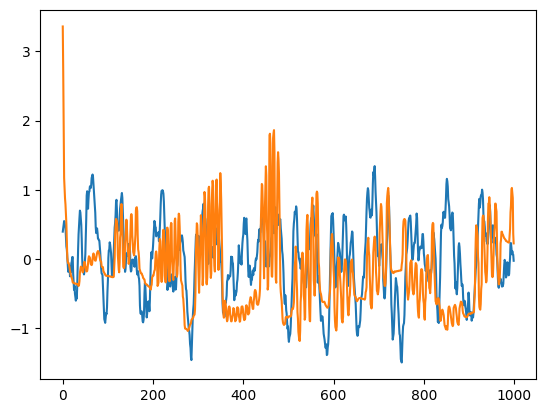

In [107]:
#DUPLICATED ORIGINAL CODE FOR TESTING METHODS
from scipy import stats
import matplotlib.pyplot as plt

# Generate feature windows for each subject
for i in range(len(train_ecog)):
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(train_ecog[i], window_length, window_overlap)
    all_train_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    downsampled_train_dg = interpolate_dataglove(train_data_glove[i], len(all_train_features))

    print(f"Subject {i+1} - Extracted features shape: {all_train_features.shape}, Dataglove shape: {downsampled_train_dg.shape}")

for i in range(len(test_ecog)):
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(test_ecog[i], window_length, window_overlap)
    all_test_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    downsampled_test_dg = interpolate_dataglove(test_data_glove[i], len(all_test_features))

    print(f"Subject {i+1} - Extracted features shape: {all_test_features.shape}, Dataglove shape: {downsampled_test_dg.shape}")

# Preparing the data
X_train, Y_train = prepare_data(all_train_features, downsampled_train_dg, lag=3)  # lag=3 corresponds to 150 ms if each step is 50 ms
X_test, Y_test = prepare_data(all_test_features, downsampled_test_dg, lag=3)

beta = ridgePrediction(X_train, Y_train)
preds = np.matmul(X_test, beta)


trainPreds = moving_average_interpolated(preds, 10)

print("Finger 1:", stats.pearsonr(trainPreds[:, 0], Y_test[:, 0])[0])
print("Finger 2:", stats.pearsonr(trainPreds[:, 1], Y_test[:, 1])[0])
print("Finger 3:", stats.pearsonr(trainPreds[:, 2], Y_test[:, 2])[0])
print("Finger 4:", stats.pearsonr(trainPreds[:, 3], Y_test[:, 3])[0])
print("Finger 5:", stats.pearsonr(trainPreds[:, 4], Y_test[:, 4])[0])

plt.plot(trainPreds[:1000,1])
plt.plot(Y_test[:1000, 1])

# Interpolate the predictions
_, interpolated_predictions = cubic_spline_interpolation(trainPreds, old_freq=20, new_freq=1000, total_duration=total_duration)

# Padding to match the original data's length
padded_predictions = pad_data(interpolated_predictions, original_length)

# Calculate correlation if dimensions are confirmed to be aligned
correlations = calculate_correlations(test_data_glove[2], padded_predictions)
print("Correlation Coefficients per Finger:", correlations)


Subject 1 - Extracted features shape: (3999, 496), Dataglove shape: (3999, 5)
Subject 1 - Extracted features shape: (1999, 496), Dataglove shape: (1999, 5)
Finger 1: 0.3412707254789784
Finger 2: 0.5269319877852513
Finger 3: 0.11816031071230863
Finger 4: 0.42310111036442666
Finger 5: 0.1811626956499251
(99850, 5)
Correlation Coefficients per Finger: [np.float64(0.34212673274283206), np.float64(0.5277143245733321), np.float64(0.11604908092549762), np.float64(0.4204650240225687), np.float64(0.1786519410061931)]


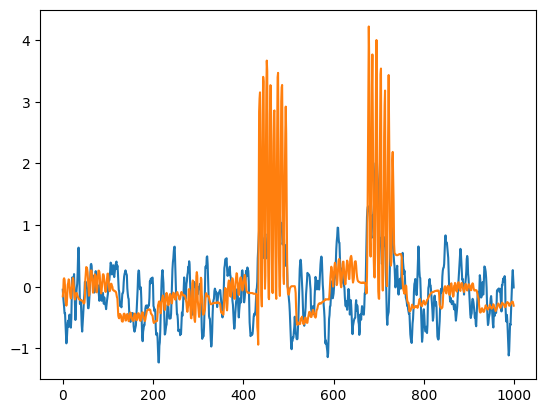

In [108]:
#DUPLICATED SCRATCHPAD CODE FOR TESTING METHODS

from scipy import stats
import matplotlib.pyplot as plt
# '''
# Generate feature windows for each subject
for i in [0]:
    window_length = 100  # ms
    window_overlap = 50  # ms
    feature_windows = gen_windows(train_ecog[i], window_length, window_overlap)
    all_train_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    smooth_train_dg = moving_average_interpolated(train_data_glove[i], 10)
    downsampled_train_dg = interpolate_dataglove(smooth_train_dg, len(all_train_features))

    print(f"Subject {i+1} - Extracted features shape: {all_train_features.shape}, Dataglove shape: {downsampled_train_dg.shape}")

    feature_windows = gen_windows(test_ecog[i], window_length, window_overlap)
    all_test_features = np.array([extract_features(window) for window in feature_windows])

    # Interpolate dataglove data to match the number of feature windows
    smooth_test_dg = moving_average_interpolated(test_data_glove[i], 10)
    downsampled_test_dg = interpolate_dataglove(smooth_test_dg, len(all_test_features))

    print(f"Subject {i+1} - Extracted features shape: {all_test_features.shape}, Dataglove shape: {downsampled_test_dg.shape}")

# Preparing the data
X_train, Y_train = prepare_data(all_train_features, downsampled_train_dg, lag=3)  # lag=3 corresponds to 150 ms if each step is 50 ms
X_test, Y_test = prepare_data(all_test_features, downsampled_test_dg, lag=3)

beta = ridgePrediction(X_train, Y_train)
preds = np.matmul(X_test, beta)

# '''
trainPreds = moving_average_interpolated(preds, 8)

print("Finger 1:", stats.pearsonr(trainPreds[:, 0], Y_test[:, 0])[0])
print("Finger 2:", stats.pearsonr(trainPreds[:, 1], Y_test[:, 1])[0])
print("Finger 3:", stats.pearsonr(trainPreds[:, 2], Y_test[:, 2])[0])
print("Finger 4:", stats.pearsonr(trainPreds[:, 3], Y_test[:, 3])[0])
print("Finger 5:", stats.pearsonr(trainPreds[:, 4], Y_test[:, 4])[0])

plt.plot(trainPreds[:1000,1])
plt.plot(Y_test[:1000, 1])

# Interpolate the predictions
_, interpolated_predictions = cubic_spline_interpolation(trainPreds, old_freq=20, new_freq=1000, total_duration=total_duration)

# Padding to match the original data's length
padded_predictions = pad_data(interpolated_predictions, original_length)

# Calculate correlation if dimensions are confirmed to be aligned
correlations = calculate_correlations(test_data_glove[0], padded_predictions)
print("Correlation Coefficients per Finger:", correlations)


In [68]:
#FINAL IMPLEMENTATION
predicted_dg_python = []

LBecog = pred_data['leaderboard_ecog']
allBetas = []

#TRAIN BETA ON WHOLE DATASET
for i in range(len(ecog)):
  window_length = 100  # ms
  window_overlap = 50  # ms
  feature_windows = gen_windows(ecog[i][0], window_length, window_overlap)
  pred_windows = gen_windows(LBecog[i][0], window_length, window_overlap)

  # Generate feature windows
  all_features = np.array([extract_features(window) for window in feature_windows])
  pred_features = np.array([extract_features(window) for window in pred_windows])

  # Interpolate dataglove data to match the number of feature windows
  downsampled_dg = interpolate_dataglove(data_glove[i][0], len(all_features))

  print(f"Subject {i+1} - Extracted features shape: {all_features.shape}, Dataglove shape: {downsampled_dg.shape}")
  print(f"Subject {i+1} - Extracted features shape: {pred_features.shape}")

  lagVal = 3

  X, Y = prepare_data(all_features, downsampled_dg, lagVal)  # lag=3 corresponds to 150 ms if each step is 50 ms
  beta = ridgePrediction(X, Y)

  X_pred = np.array([pred_features[i:i+lagVal].flatten() for i in range(len(pred_features) - lagVal + 1)])

  #Generate predictions for leaderboard data
  print(X_pred.shape)
  print(beta.shape)
  roughPreds = np.matmul(X_pred, beta)

  allPreds = moving_average_interpolated(roughPreds, 8)

  #Interpolate and structure for submission

  # Assume Y_hat are the predicted values at 20 Hz (every 50 ms), and the original data length was at 1000 Hz
  original_length = len(pred_data['leaderboard_ecog'][i][0])  # Calculate original length assuming original data was 1000 Hz over the same time period
  total_duration = len(allPreds) * 0.05  # Total duration in seconds

  # Interpolate the predictions
  _, interpolated_predictions = cubic_spline_interpolation(allPreds, old_freq=20, new_freq=1000, total_duration=total_duration)

  # Padding to match the original data's length
  padded_predictions = pad_data(interpolated_predictions, original_length)

  print("Interpolated and Padded Predictions Shape:", padded_predictions.shape)

  predicted_dg_python.append(padded_predictions)

  allBetas.append(beta)

Subject 1 - Extracted features shape: (5999, 496), Dataglove shape: (5999, 5)
Subject 1 - Extracted features shape: (2949, 496)
(2947, 1488)
(1488, 5)
(147350, 5)
Interpolated and Padded Predictions Shape: (147500, 5)
Subject 2 - Extracted features shape: (5999, 384), Dataglove shape: (5999, 5)
Subject 2 - Extracted features shape: (2949, 384)
(2947, 1152)
(1152, 5)
(147350, 5)
Interpolated and Padded Predictions Shape: (147500, 5)
Subject 3 - Extracted features shape: (5999, 512), Dataglove shape: (5999, 5)
Subject 3 - Extracted features shape: (2949, 512)
(2947, 1536)
(1536, 5)
(147350, 5)
Interpolated and Padded Predictions Shape: (147500, 5)


In [ ]:
# Convert the dictionary to a MATLAB cell array structure
predicted_dg = {'cell_array': scipy.io.matlab.mio5_params.mat_struct()}
for key, value in predicted_dg_python.items():
    predicted_dg['cell_array'].__dict__[key] = value

# Save the MATLAB cell array to a .mat file
scipy.io.savemat('5210_predicted_dg.mat', predicted_dg)

<ipython-input-22-acf39583d0a7>:2: DeprecationWarning: Please import `mat_struct` from the `scipy.io.matlab` namespace; the `scipy.io.matlab.mio5_params` namespace is deprecated and will be removed in SciPy 2.0.0.
  predicted_dg = {'cell_array': scipy.io.matlab.mio5_params.mat_struct()}


AttributeError: 'list' object has no attribute 'items'

In [ ]:
plt.plot(predicted_dg_python['Subject 1'][:10000])

<class 'list'>
<class 'numpy.ndarray'>
(147500, 5)


In [ ]:
allBetasArray = np.array(allBetas, dtype = 'object')
allBetasArray.dump('allBetas.pkl')